In [1]:
# --- Standard modules
import pickle as pkl
import numpy as np
import heapq as hq
from icecream import ic
# --- PyTorch
import torch
# --- PyG
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx
# --- NetworkX
import networkx as nx
# --- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# --- Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import imageio
# --- Bokeh
from bokeh.io import output_notebook, show
output_notebook()
# --- Science python
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
# --- Modules from local files
from GNN_atom import GNN
from Dataset import XASDataset
from train import train_atom
from test import test_atom
from utils import plot_learning_curve, bokeh_spectra, calculate_rse
rdkit.__version__

c:\Users\a3782\AppData\Local\anaconda3\envs\pyg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

'2023.09.5'

#### Define functions to be used

In [2]:
def pred_spec(model, index, test_dataset):
    # --- Set the model to evaluation mode
    model.eval()

    # --- Get a single graph from the test dataset
    graph_index = index # Index of the graph you want to predict on
    graph_data = test_dataset[graph_index].to(device)
    batch = Batch.from_data_list([graph_data])
    #print(batch.atom_num)


    # --- Pass the graph through the model
    with torch.no_grad():
        pred, a, b, c = model(batch)
    
    # ---  the predicted output for the single graph
    pred_graph = pred[0]
    true_spectrum = graph_data.y.cpu().numpy()
    predicted_spectrum = pred.cpu().numpy()
    predicted_spectrum = predicted_spectrum.reshape(-1)
    
    return predicted_spectrum, true_spectrum

#### Load dataset

In [3]:
# --- Path raw directory containing the data
path = "./"
# --- Load and create the dataset
dataset = XASDataset(path)

In [4]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[31]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASDataset(7946)
------------
Number of graphs: 7946
Number of features: 15
Number of classes: 0

Data(x=[29, 15], edge_index=[2, 72], edge_attr=[72, 6], spectrum=[200], vector=[15], idx=[1], smiles='[c:0]12[c:2]3[cH:1][cH:24][c:23]4[c:21]1[c:17]1[c:13]5[c:9]6[c:11]([cH:12][cH:14][c:15]5[cH:16][c:18]([CH:25]=[O:28])[c:19]1[cH:20][cH:22]4)[CH2:10][CH:8]1[C:7]([C:5]26[OH:26])([CH:6]=[C:3]3[OH:4])[O:27]1', atom_num=[1], neighbors=[4])
------------
Number of nodes: 29
Number of edges: 72
Average node degree: 2.48
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [5]:
torch.save(dataset, './XASNet-data/atom_dataset.pt')

#### View data

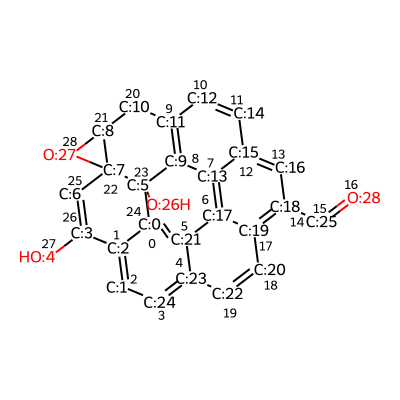

In [6]:
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
mol = Chem.MolFromSmiles(data.smiles)
mol

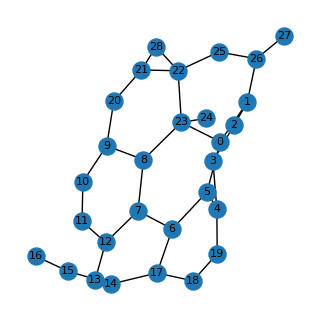

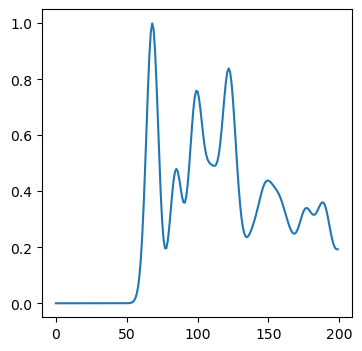

In [7]:
# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)

plt.figure(figsize=(3,3))

nx.draw(mol_graph, with_labels=True, node_size=150, font_size=8)

plt.show()

# --- Show an atomic spectrum from molecule
plt.figure(figsize=(4,4))

plt.plot(data.spectrum)

plt.show()

#### Split up dataset

In [8]:
# --- Split into test, validation and test
train_dataset = dataset[0:2]
val_dataset = dataset[4:9]
test_dataset = dataset[7152:7946]

# --- Pass into dataloader
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

print(f'Length of training data loader: {len(train_loader.dataset)}, with a total of {len(train_loader)} datasets')
print(f'Length of validation data loader: {len(val_loader.dataset)}, with a total of {len(val_loader)} datasets')
print(f'Length of testing data loader: {len(test_loader.dataset)}, with a total of {len(test_loader)} datasets')

Length of training data loader: 2, with a total of 2 datasets
Length of validation data loader: 5, with a total of 1 datasets
Length of testing data loader: 794, with a total of 397 datasets


In [9]:
print(train_loader.dataset[0])
print(train_loader.dataset[0].vector)
print(train_loader.dataset[0].atom_num)
print(train_loader.dataset[0].neighbors)

Data(x=[32, 15], edge_index=[2, 78], edge_attr=[78, 6], spectrum=[200], vector=[15], idx=[1], smiles='[c:0]12[c:4]3[c:8]4[c:10]5[c:11]([CH:25]=[O:29])[cH:13][c:14]6[c:12]4[c:17]4[c:19]([c:18]([CH:26]=[O:31])[c:15]6[OH:16])=[CH:20][CH:22]6[C:23]([c:21]14)([CH:24]=[CH:1][C:2]2=[CH:3][CH2:5][C:6]3([CH:27]=[O:30])[CH:7]=[CH:9]5)[O:28]6', atom_num=[1], neighbors=[3])
tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.9844,
        0.0156, 0.0000, 0.0000, 0.9844, 0.0156, 0.5625])
tensor([18])
[17, 19, 31]


#### Set neural network properties

In [10]:
num_tasks = 200
num_layers = 3
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 100, 150]
out_channels = [100, 150, 200]
gnn_type = 'gcn'
heads = int(1)
drop_ratio = 0.0
graph_pooling = 'mean'

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)
print('----')
print(f'Training will be performed on: {device}')

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(15, 100)
      (1): GCNConv(100, 150)
      (2): GCNConv(150, 200)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=200, out_features=200, bias=True)
)
----
Training will be performed on: cpu


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, min_lr=0.000001)

#### Run neural network training

In [13]:
num_epochs = 300
best_val_error = None
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    
    loss, a,b,c,d, out, true = train_atom(epoch, train_loader, model, device, optimizer)
    #loss, a,b,c,d = train(epoch)
    
    plt.plot(out)
    plt.plot(true)
    #plt.plot(train_loader.dataset[0].y)
    #plt.plot(train_loader.dataset[1].y)
    plt.ylim(-0.2, 1.2)
    plt.xlim(0, 200)
    plt.title(f'epoch: {epoch}')
    plt.savefig(f'./images/graph_{epoch}.png')
    plt.close()
    
    val_error = test_atom(val_loader, model, device)
    #val_error = test(val_loader)

    scheduler.step(val_error)
    #scheduler.step(epoch)
    train_losses.append(loss)
    val_losses.append(val_error)
    
    current_lr = optimizer.param_groups[0]['lr']

    if best_val_error is None or val_error <= best_val_error:
        
        best_val_error = val_error
    if epoch%25 == 0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss:{val_error:7f}, Best_ValLoss:{best_val_error:7f}')


Epoch: 000, LR: 0.010000, TrainLoss: 0.1433069, ValLoss:0.125273, Best_ValLoss:0.125273
Epoch: 025, LR: 0.010000, TrainLoss: 0.0009004, ValLoss:0.185071, Best_ValLoss:0.107179
Epoch: 050, LR: 0.010000, TrainLoss: 0.0000677, ValLoss:0.270571, Best_ValLoss:0.107179
Epoch: 075, LR: 0.010000, TrainLoss: 0.0000402, ValLoss:0.332353, Best_ValLoss:0.107179
Epoch: 100, LR: 0.010000, TrainLoss: 0.0001145, ValLoss:0.328564, Best_ValLoss:0.107179
Epoch: 125, LR: 0.005000, TrainLoss: 0.0000187, ValLoss:0.331245, Best_ValLoss:0.107179
Epoch: 150, LR: 0.005000, TrainLoss: 0.0000082, ValLoss:0.330795, Best_ValLoss:0.107179
Epoch: 175, LR: 0.005000, TrainLoss: 0.0000067, ValLoss:0.327739, Best_ValLoss:0.107179
Epoch: 200, LR: 0.005000, TrainLoss: 0.0000057, ValLoss:0.327218, Best_ValLoss:0.107179
Epoch: 225, LR: 0.002500, TrainLoss: 0.0000052, ValLoss:0.325636, Best_ValLoss:0.107179
Epoch: 250, LR: 0.002500, TrainLoss: 0.0000048, ValLoss:0.325276, Best_ValLoss:0.107179
Epoch: 275, LR: 0.002500, TrainL

In [14]:
frames = []

for t in range(num_epochs):
    image = imageio.v2.imread(f'./images/graph_{t}.png')
    frames.append(image)

imageio.mimsave('./example.gif', frames, fps=8)

In [26]:
model_name = 'model_gnn_atom_test.pt'
torch.save(model.state_dict(), "ML_models/" + model_name)

#### View loss

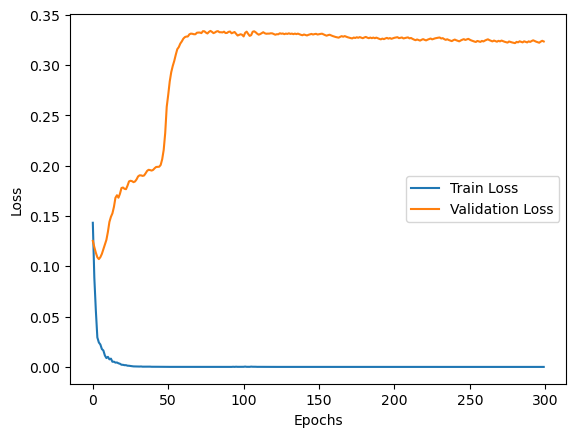

In [15]:
plot_learning_curve(num_epochs, train_losses, val_losses)

#### Load model and predict spectra

In [28]:
# Load the saved model
num_tasks = 200

model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
mode = model.to(device)
model.load_state_dict(torch.load("ML_models/" + model_name))

<All keys matched successfully>

#### Extract predicted and true spectra

In [29]:
# Create empty dictionary to contain spectra
predict = {}
true = {}

# Loop over all molecules in test dateset and assign to dictionary index
for index in range(len(test_dataset)):
    predict[index], true[index] = pred_spec(model, index, test_dataset)

# Parse spectra into dictionary
model_dict = [predict, true]

name = 'spectra_ml_atom_test.pkl'

with open('spectra_results/' + name, "wb") as file:
    pkl.dump(model_dict, file)

#### View and analyse predictions

In [30]:
file = open('spectra_results/' + name, 'rb')
data = pkl.load(file)

predict = data[0]
true = data[1]

In [31]:
wasser = []
mse = []
rse = []

for x in range(len(predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(predict[x], true[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(predict[x], true[x])
    mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(predict[x], true[x])
    rse.append(rse_temp)

print(f"Average Wasserstein distance = {sum(wasser) / len(wasser)}")
print(f"Average MSE = {sum(mse) / len(mse)}")
print(f'Average RSE = {sum(rse) / len(rse)}')

Average Wasserstein distance = 0.08579470284038876
Average MSE = 0.039418090894763474
Average RSE = 0.18670483825970044


In [32]:
five_best = hq.nsmallest(5, rse)
five_worst = hq.nlargest(5, rse)

best = []
worst = []

for x in range(5):
    best_idx = rse.index(five_best[x])
    best.append(best_idx)

    worst_idx = rse.index(five_worst[x])
    worst.append(worst_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {five_best[x]:.3f}, graph number = {best[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(5):
    print(f'RSE = {five_worst[x]:.3f}, graph number = {worst[x]}')

The 5 best RSE values are:
RSE = 0.106, graph number = 27
RSE = 0.114, graph number = 9
RSE = 0.115, graph number = 21
RSE = 0.121, graph number = 34
RSE = 0.126, graph number = 6

The 5 worst RSE values are:
RSE = 0.418, graph number = 14
RSE = 0.354, graph number = 26
RSE = 0.312, graph number = 1
RSE = 0.309, graph number = 10
RSE = 0.302, graph number = 22


In [33]:
# Plot best spectra prediction
p = bokeh_spectra(predict[best[0]], true[best[0]])
show(p)

p = bokeh_spectra(predict[best[1]], true[best[1]])
show(p)

In [34]:
# Plot worst spectra prediction
p = bokeh_spectra(predict[worst[0]], true[worst[0]])
show(p)

p = bokeh_spectra(predict[worst[1]], true[worst[1]])
show(p)